In [13]:
import numpy as np
from SimuQ.thesis.Experiment.utilities.hamiltonian_models import Ising

In [27]:
N = 6
T = 1

### Ising chain model creation

In [28]:
h = np.array([1 for j in range(N)])
J_chain = np.zeros((N, N))
for j in range(N - 1):
    J_chain[j, j + 1] = 1

J_cycle = np.copy(J_chain)
J_cycle[0, N - 1] = 1

Ising_chain = Ising(N, T, J_chain, h)

### Initialization step

In [22]:
from qiskit_ibm_provider import IBMProvider
from simuq.provider import BaseProvider
from simuq.solver import generate_as

In [29]:
#Init parameters of the IBMProvider
qs = Ising_chain
hub = "ibm-q-ncsu"
group = "nc-state"
project = "quantum-compiler"
api_file = "../ibm_API_key"
aais = 'heisenberg'
backend = 'ibmq_mumbai'
tol = 0.01
trotter_num = 6
verbose = 0
use_pulse = True
state_prep = None

In [24]:
#Init functionality of the IBMProvider
from qiskit import IBMQ
with open(api_file, "r") as f:
        api_key = f.readline().strip()

provider = IBMQ.enable_account(api_key, hub='ibm-q-ncsu', group='nc-state', project='quantum-compiler')

IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

### Compilation step

In [30]:
backend = provider.get_backend(backend)
nsite = backend.configuration().n_qubits

if qs.num_sites > nsite:
    raise Exception("Device has less sites than the target quantum system.")

if aais == "heisenberg":
    import ibm
    from qiskit_pulse_ibm import transpile

    mach = ibm.generate_qmachine(backend)
    comp = transpile

In [31]:
layout, sol_gvars, boxes, edges = generate_as(
    qs,
    mach,
    trotter_num,
    solver="least_squares",
    solver_args={"tol": tol},
    override_layout=None,
    verbose=verbose,
)

In [9]:
circ = []

for i in range(6):
    circ.append(comp(
        backend,
        layout,
        sol_gvars,
        boxes,
        edges,
        use_pulse=True,
        noise_factor=i
    ))

C:\Users\Admin\.conda\envs\thesis\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


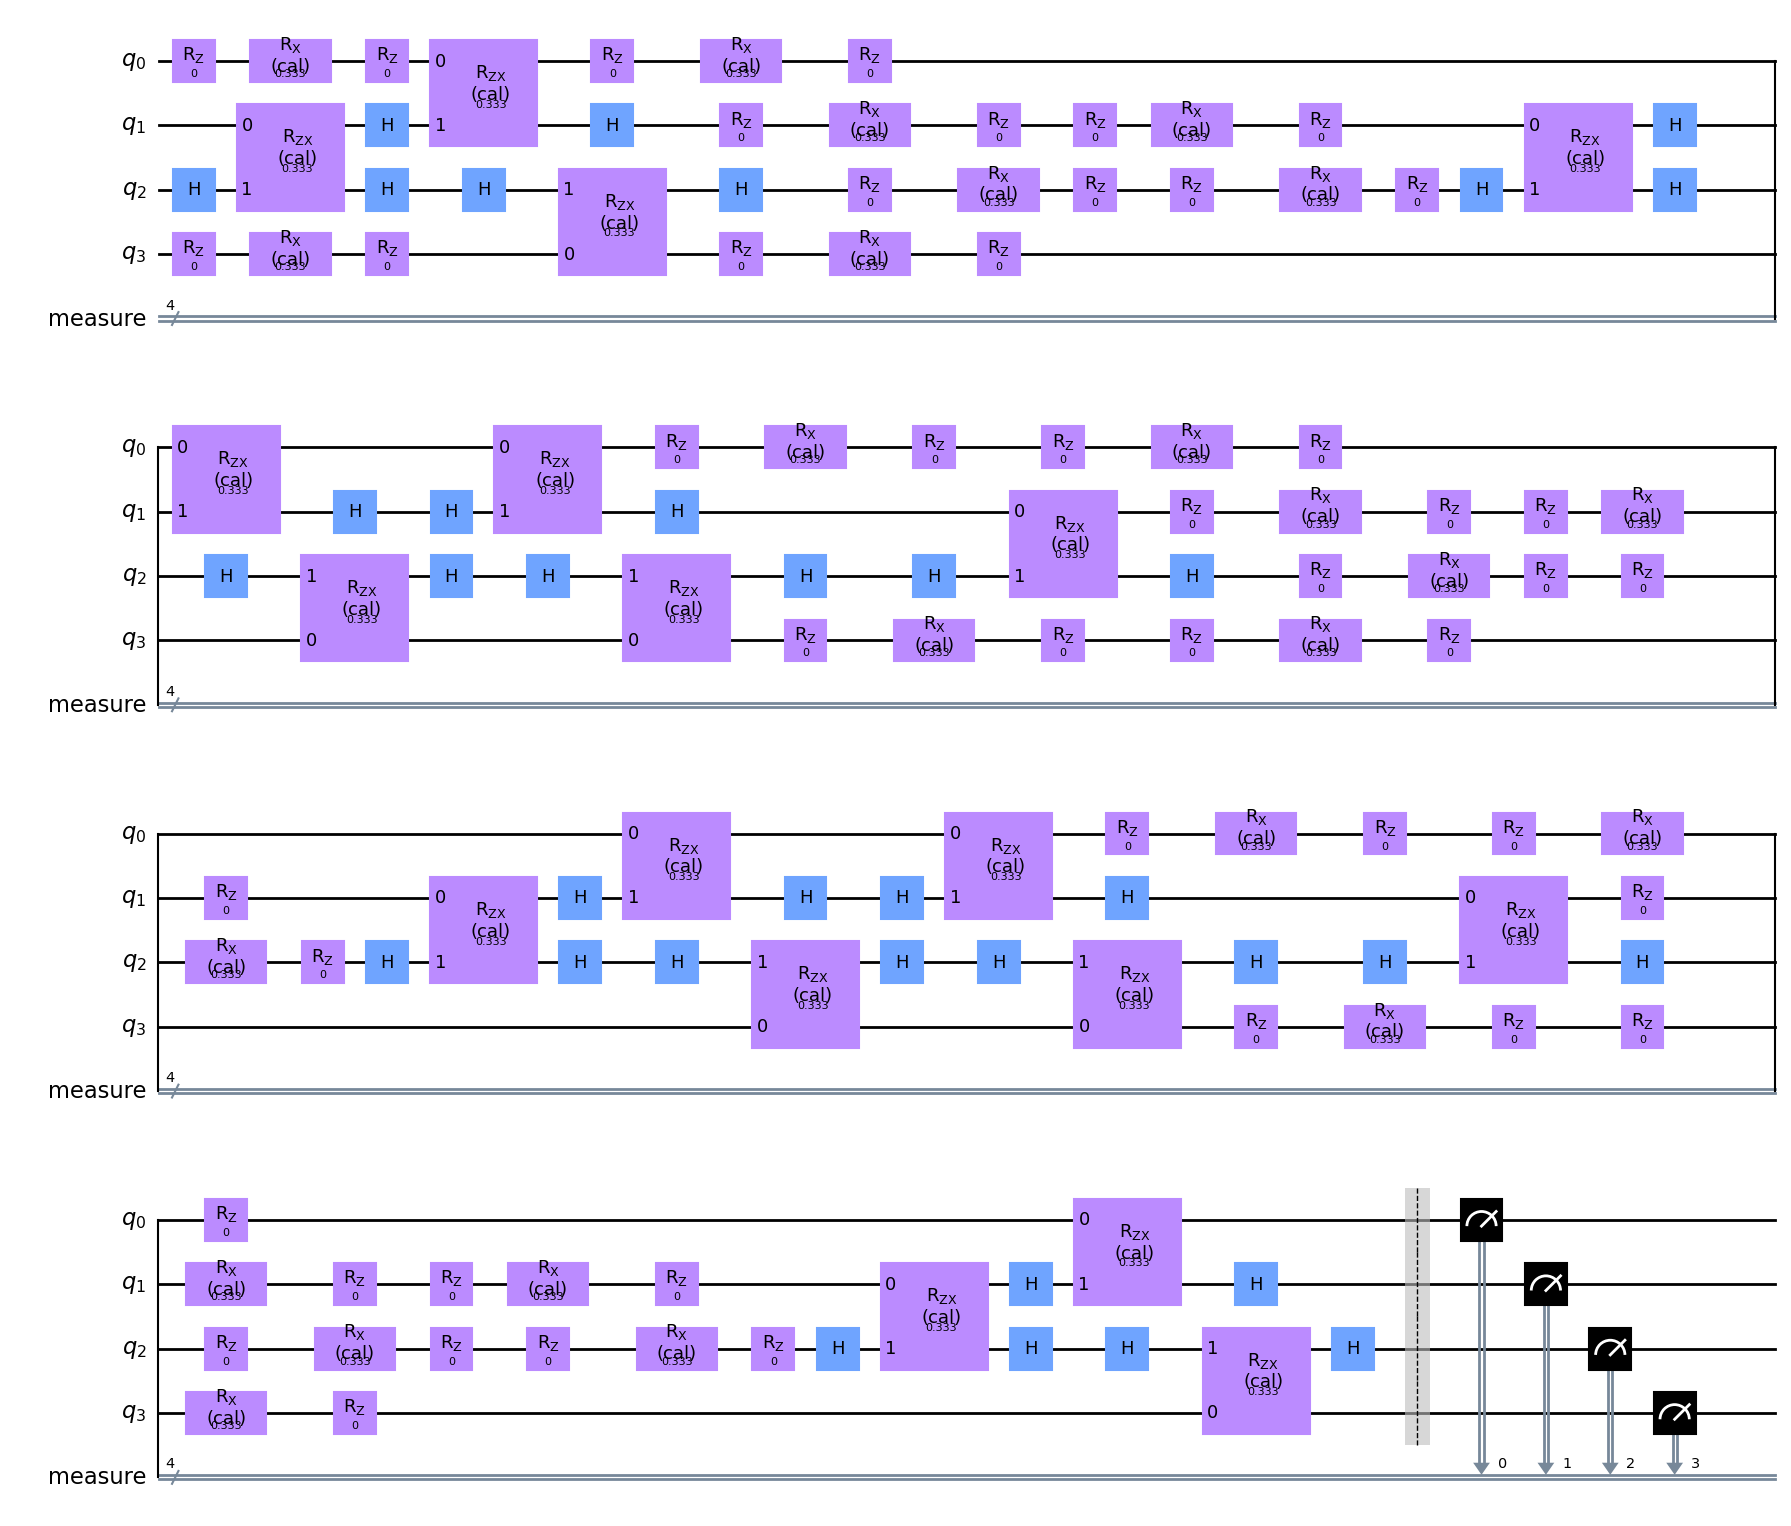

In [10]:
circ[0].draw('mpl',idle_wires=False)

In [45]:
circ[5].count_ops()

OrderedDict([('rz', 528),
             ('h', 396),
             ('rx', 264),
             ('rzx', 198),
             ('measure', 27),
             ('barrier', 1)])

In [51]:
circ[5].depth()

595

In [55]:
circ[0].calibrations

{'rzx': {((3, 2),
   (0.33333333402942117,)): ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.19582746565882173, angle=0.2512715211673603), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.033952943376134685, angle=-0.0357733676092752), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.8297042628366826, amp=0.16244388739127907, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.19582746565882173, angle=-2.890321132422433), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.033952943376134685, angle=3.105819285980518), Dr

In [11]:
from qiskit import transpile as transpile_qiskit
transpiled_circ = []

for i in range(len(circ)):
    transpiled_circ.append(transpile_qiskit(circ[i],backend))

In [17]:
transpiled_circ[5].count_ops()

OrderedDict([('rzx', 198),
             ('rz', 53),
             ('sx', 30),
             ('measure', 27),
             ('barrier', 1)])

In [29]:
transpiled_circ[5].depth()

170

In [56]:
transpiled_circ[0].calibrations

{'rzx': {((3, 2),
   (0.33333333402942117,)): ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.19582746565882173, angle=0.2512715211673603), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.033952943376134685, angle=-0.0357733676092752), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.8297042628366826, amp=0.16244388739127907, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.19582746565882173, angle=-2.890321132422433), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.033952943376134685, angle=3.105819285980518), Dr

C:\Users\Admin\.conda\envs\thesis\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


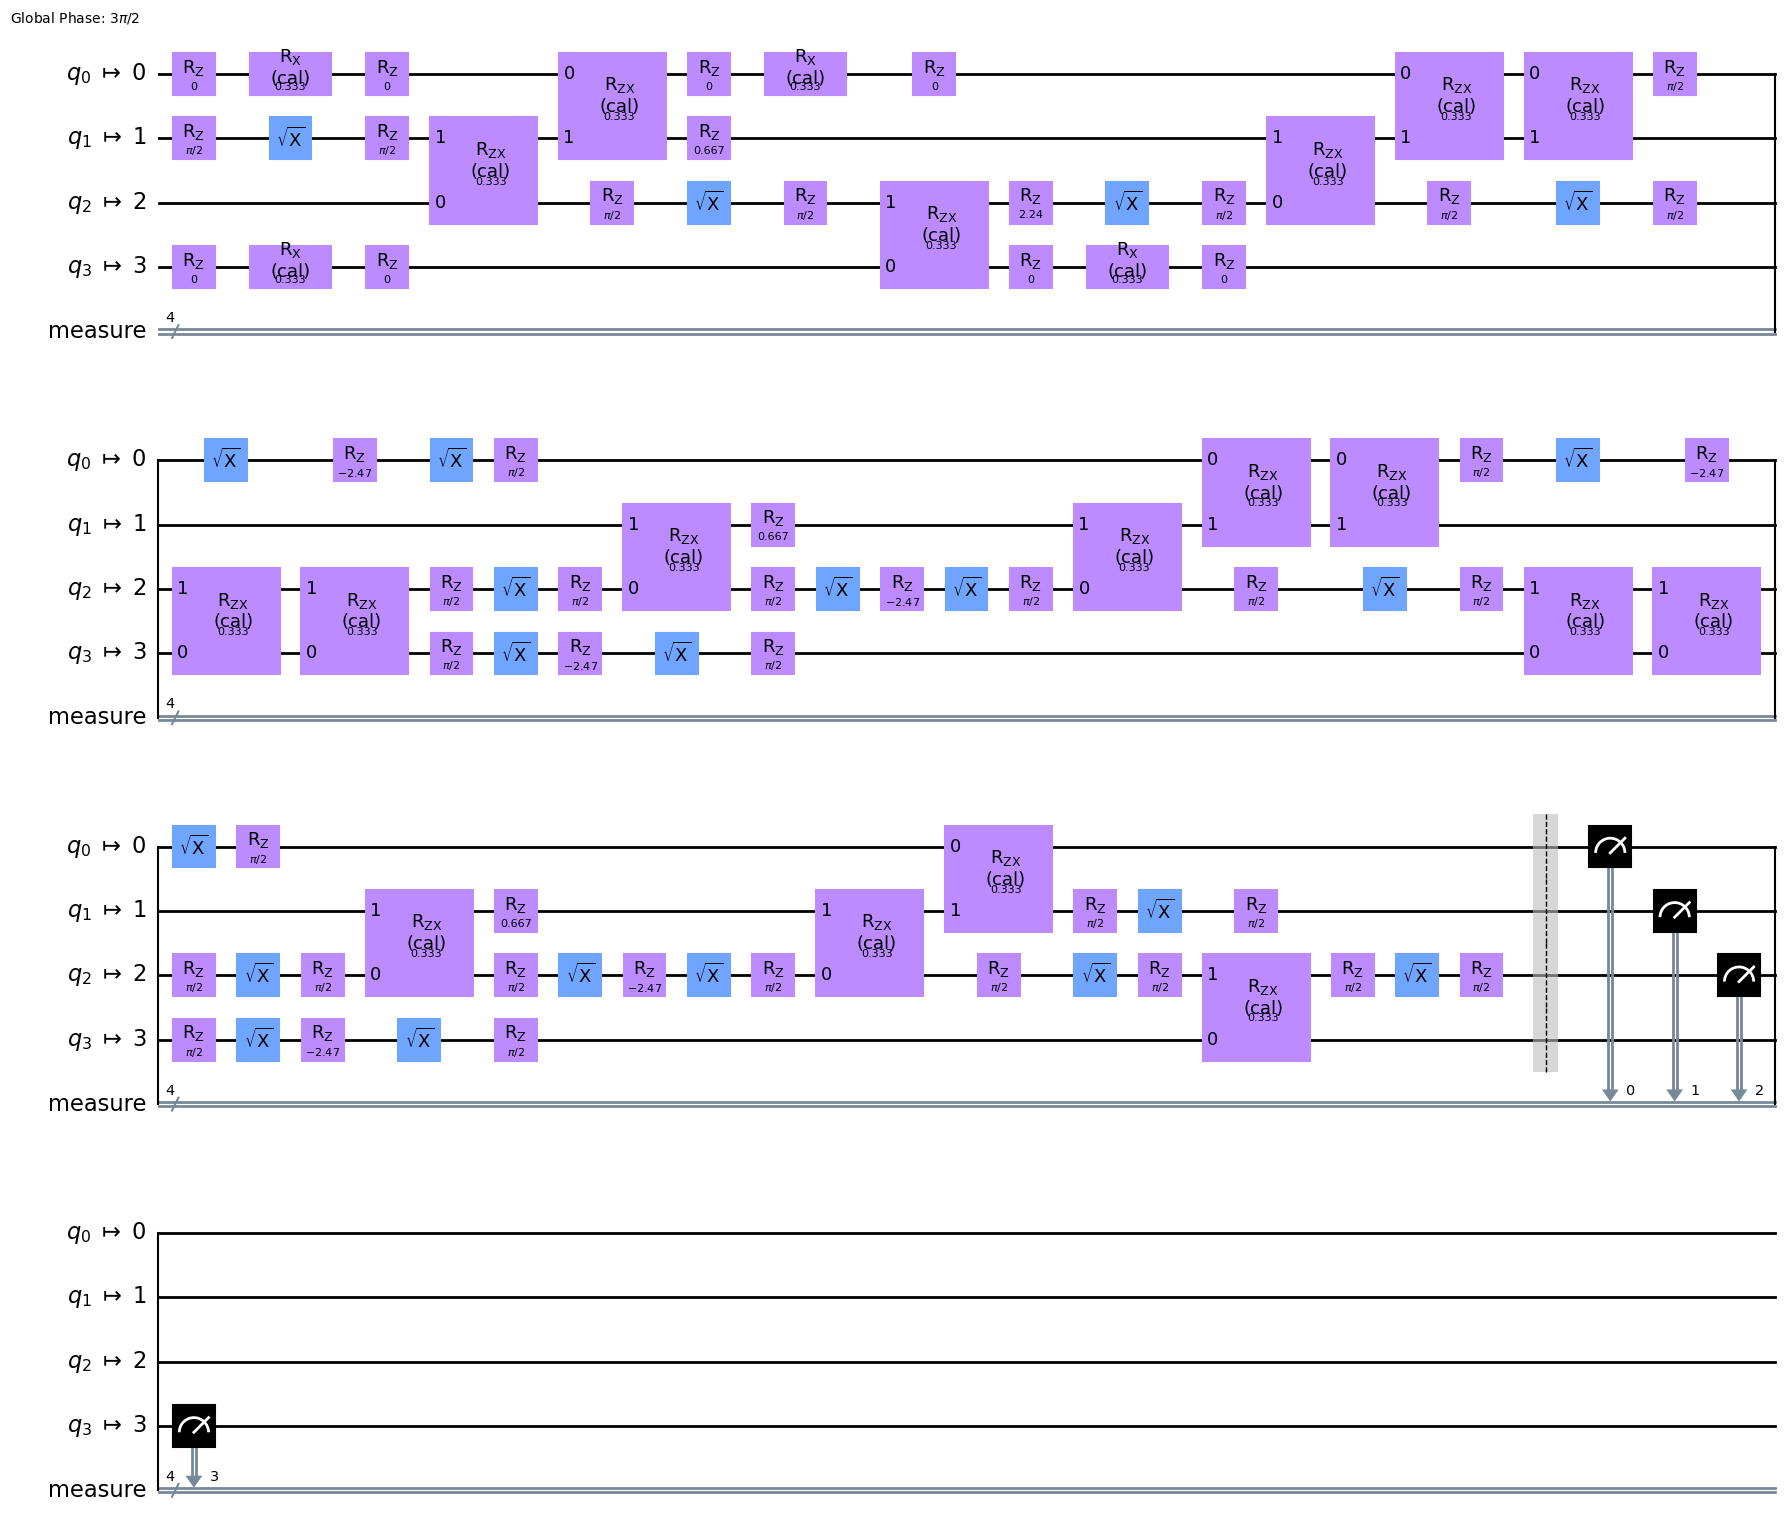

In [13]:
transpiled_circ[0].draw('mpl',idle_wires=False)

In [12]:
from qiskit import execute
for i in range(len(transpiled_circ)):
    job = execute([transpiled_circ[i]] * 5, shots=1024, backend=backend)
    print(job.job_id())

cnkt0s3takkg008rf7zg
cnkt0wv7aw9g008gj3cg
cnkt10ctakkg008rf810
cnkt11wtpj7000841xcg
cnkt134tpj7000841xd0
cnkt14mtpj7000841xdg
